In [2]:
import time
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.font_manager as fm


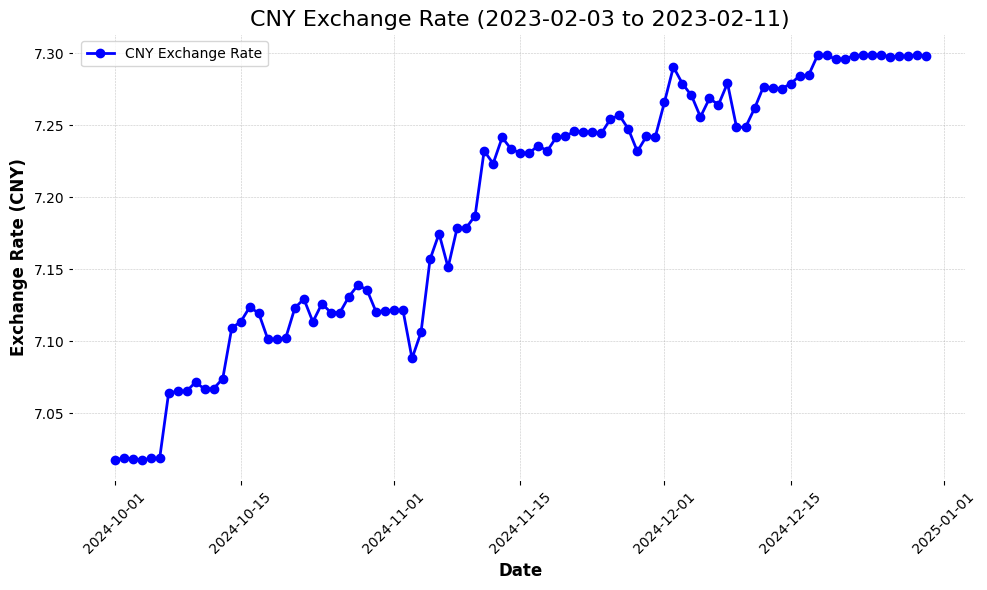

In [3]:

start_date = "2024-10-01"
end_date = "2024-12-30"
currency_latest_df = ak.currency_time_series(base="USD", symbols="CNY", start_date=start_date, end_date=end_date, api_key= Currencybeacon_API_KEY)

currency_latest_df["date"] = pd.to_datetime(currency_latest_df["date"])
currency_latest_df.set_index("date", inplace=True)

# 绘制折线图
plt.figure(figsize=(10, 6))  # 设置图像大小
plt.plot(currency_latest_df.index, currency_latest_df["CNY"], marker="o", linestyle="-", color="b", label="CNY Exchange Rate")
# 添加标题和标签
plt.title("CNY Exchange Rate (2023-02-03 to 2023-02-11)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Exchange Rate (CNY)", fontsize=12)
# 添加网格
plt.grid(True, linestyle="--", alpha=0.6)

# 添加图例
plt.legend()

# 旋转日期标签
plt.xticks(rotation=45)
# 显示图像
plt.tight_layout()  # 调整布局
# plt.show()

# 保存图像
plt.savefig("plot.png", dpi=300)


显示图标


In [ ]:
import datetime
import os
from sqlalchemy import create_engine
import toml
import pandas as pd

CONFIG = toml.load(os.getenv('ENV', 'development') + '.toml')
DATABASE_URL = 'mysql+pymysql://%(user)s:%(password)s@%(host)s:%(port)d/%(db)s?charset=%(charset)s' % CONFIG['pymysql']
engine = create_engine(DATABASE_URL)

query = "SELECT * FROM a_stock_daily_data WHERE date > '2024-01-01'"
df = pd.read_sql_query(query, con=engine)
df.set_index('date', inplace=True)
mpf.plot(df, type='candle', volume=True, style='charles', title='Stock candle trend chart', ylabel='price', ylabel_lower='trading volume')

NameError: name 'pd' is not defined